In [159]:
import time

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 6]

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, v_measure_score, adjusted_rand_score, homogeneity_score, calinski_harabasz_score

In [183]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

In [139]:
random_state = 2020

X_cred, y_cred = fetch_openml("credit-g", return_X_y=True)
X_mnist, y_mnist = fetch_openml('mnist_784', version=1, return_X_y=True)

X_cred = pd.DataFrame(X_cred)
y_cred = pd.DataFrame(y_cred)

X_mnist = pd.DataFrame(X_mnist)
y_mnist = pd.DataFrame(y_mnist)

# mapped_back_to_string_label = mapping.take(results)
y_cred[0], cred_mapping = pd.factorize(y_cred[0])
y_mnist[0], mnist_mapping = pd.factorize(y_mnist[0], sort=True)

# Create holdout test set
X_cred_train, X_cred_test, y_cred_train, y_cred_test = train_test_split(X_cred, y_cred, test_size=0.2,
                                                                        random_state=random_state,
                                                                        stratify=y_cred)

X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist, test_size=0.2,
                                                                            random_state=random_state,
                                                                            stratify=y_mnist)

def get_data(data):
    return data["X"], data["y"], data["name"]

# Standardize
scaler_cred = StandardScaler()
scaler_cred.fit(X_cred_train)
X_cred_train = pd.DataFrame(scaler_cred.transform(X_cred_train), index=y_cred_train.index)
X_cred_test = pd.DataFrame(scaler_cred.transform(X_cred_test), index=y_cred_test.index)

scaler_cred_full = StandardScaler()
scaler_cred_full.fit(X_cred)
X_cred = pd.DataFrame(scaler_cred_full.transform(X_cred), index=y_cred.index)


X_mnist_train = pd.DataFrame(X_mnist_train / 255.0, index=y_mnist_train.index)
X_mnist_test = pd.DataFrame(X_mnist_test / 255.0, index=y_mnist_test.index)
X_mnist = pd.DataFrame(X_mnist / 255.0, index=y_mnist.index)

# Create data sets
cred = {"X": X_cred_train, "y": y_cred_train, "name": "Credit Train"}
cred_test = {"X": X_cred_test, "y": y_cred_test, "name": "Credit Test"}
cred_full = {"X": X_cred, "y": y_cred, "name": "Credit Full"}

mnist = {"X": X_mnist_train, "y": y_mnist_train, "name": "MNIST Train"}
mnist_test = {"X": X_mnist_test, "y": y_mnist_test, "name": "MNIST Test"}
mnist_full = {"X": X_mnist, "y": y_mnist, "name": "MNIST Full"}

In [3]:
def build_kmeans_elbow_data(data_set, max_k=15):
    X, y, name = get_data(data_set)
    
    km_scores= []
    km_silhouette = []
    vmeasure_score =[]
    db_score = []
        
    print("="*100)
    for i in range(2,max_k):
        print("Clusters: ", i)

        km = KMeans(n_clusters=i,
                    init="k-means++",
                    n_jobs=-1,
                    verbose=2,
                    precompute_distances=True,
                    random_state=random_state).fit(X)
        preds = km.predict(X)
    
        # Kmeans score
        print("K-means score:        {}".format(km.score(X)))
        km_scores.append(-km.score(X))

        # Silhouette score
        silhouette = silhouette_score(X,preds)
        km_silhouette.append(silhouette)
        print("Silhouette score:     {}".format(silhouette))
    
        # Davies Boulding score
        db = davies_bouldin_score(X,preds)
        db_score.append(db)
        print("Davies Bouldin score: {}".format(db))
    
        # V-measure score   
        v_measure = v_measure_score(y.values.ravel(), preds)
        vmeasure_score.append(v_measure)
        print("V-measure score:      {}".format(v_measure))
        print("-"*100)
    
    return (km_scores, km_silhouette, vmeasure_score, db_score)

In [4]:
def build_kmeans_plots(title, k, s, v, d, clusters=None):
    if clusters is None:
        clusters = range(2, len(k) + 2)
        
    _, axes = plt.subplots(1, 4, figsize=(28, 7))
    
    axes[0].set_title(title + " - K-means Score")
    axes[0].set_xlabel("Clusters")
    axes[0].set_ylabel("K-means Score")
    axes[0].set_xticks(clusters)
    axes[0].grid()
    axes[0].plot(clusters, k, '-o')
    
    axes[1].set_title(title + " - Silhouette Score")
    axes[1].set_xlabel("Clusters")
    axes[1].set_ylabel("Silhouette Score")
    axes[1].set_xticks(clusters)
    axes[1].grid()
    axes[1].plot(clusters, s, '-o')
   
    axes[2].set_title(title + " - Davies Boulding Score")
    axes[2].set_xlabel("Clusters")
    axes[2].set_ylabel("Davies Boulding Score")
    axes[2].set_xticks(clusters)
    axes[2].grid()
    axes[2].plot(clusters, d, '-o')

    axes[3].set_xlabel("Clusters")
    axes[3].set_ylabel("V-measure score")
    axes[3].set_xticks(clusters)
    axes[3].grid()
    axes[3].plot(clusters, v, '-o')
    
    plt.show()

In [5]:
def build_gmm_data(data_set, max_k=15):
    X, y, name = get_data(data_set)

    gm_bic= []
    gm_score=[]
    
    print("="*100)
    for i in range(2,max_k):
        print("Clusters: ", i)
        gm = GaussianMixture(n_components=i
                             ,n_init=10,
                             tol=1e-3,
                             max_iter=1000).fit(X)
        print("BIC:            {}".format(gm.bic(X)))
        print("Log-likelihood: {}".format(gm.score(X)))
        print("-"*100)
        gm_bic.append(gm.bic(X))
        gm_score.append(gm.score(X))
    return (gm_bic, gm_score)

In [6]:
def build_gmm_plots(title, gm_bic, gm_score, clusters=None):
    if clusters is None:
        clusters = range(2, len(gm_bic) + 2)
        
    _, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    axes[0].set_title(title + " - BIC Score")
    axes[0].set_xlabel("Clusters")
    axes[0].set_ylabel("BIC Score")
    axes[0].set_xticks(clusters)
    axes[0].grid()
    axes[0].plot(clusters, gm_bic, '-o')
    
    axes[1].set_title(title + " - Log-likelihood Score")
    axes[1].set_xlabel("Clusters")
    axes[1].set_ylabel("Log-likelihood Score")
    axes[1].set_xticks(clusters)
    axes[1].grid()
    axes[1].plot(clusters, gm_score, '-o')

In [7]:
def show_digits(data_set, digit_ids, title):
    X, y, name = get_data(data_set)
    
    fig, axes = plt.subplots(nrows=10, ncols=10, sharex=True)
    fig.set_figheight(7)
    fig.set_figwidth(7)
    fig.suptitle(title, fontsize=12)

    image_id = 0
    for i in range(10):
        for j in range(10):
            axes[i][j].imshow(X.loc[digit_ids[image_id], :].values.reshape([28,28]), cmap=plt.get_cmap('gray'))
            axes[i][j].xaxis.set_major_locator(plt.NullLocator())
            axes[i][j].yaxis.set_major_locator(plt.NullLocator())

            image_id += 1

# Credit

## K-means

In [8]:
ck, cs, cv, cd = build_kmeans_elbow_data(cred_full)

Clusters:  2
K-means score:        -18341.36520681746
Silhouette score:     0.08265747730115564
Davies Bouldin score: 3.2285992467274975
V-measure score:      4.2763656485364575e-05
----------------------------------------------------------------------------------------------------
Clusters:  3
K-means score:        -17328.559818966598
Silhouette score:     0.0737886948647417
Davies Bouldin score: 2.9676422088978014
V-measure score:      0.05471136175490483
----------------------------------------------------------------------------------------------------
Clusters:  4
K-means score:        -16454.85933292188
Silhouette score:     0.07499173202052042
Davies Bouldin score: 2.719576994173041
V-measure score:      0.052210166465387495
----------------------------------------------------------------------------------------------------
Clusters:  5
K-means score:        -15700.481647773297
Silhouette score:     0.0858871793146497
Davies Bouldin score: 2.435596235807515
V-measure score:     

In [9]:
ctitle = "Credit Dataset"

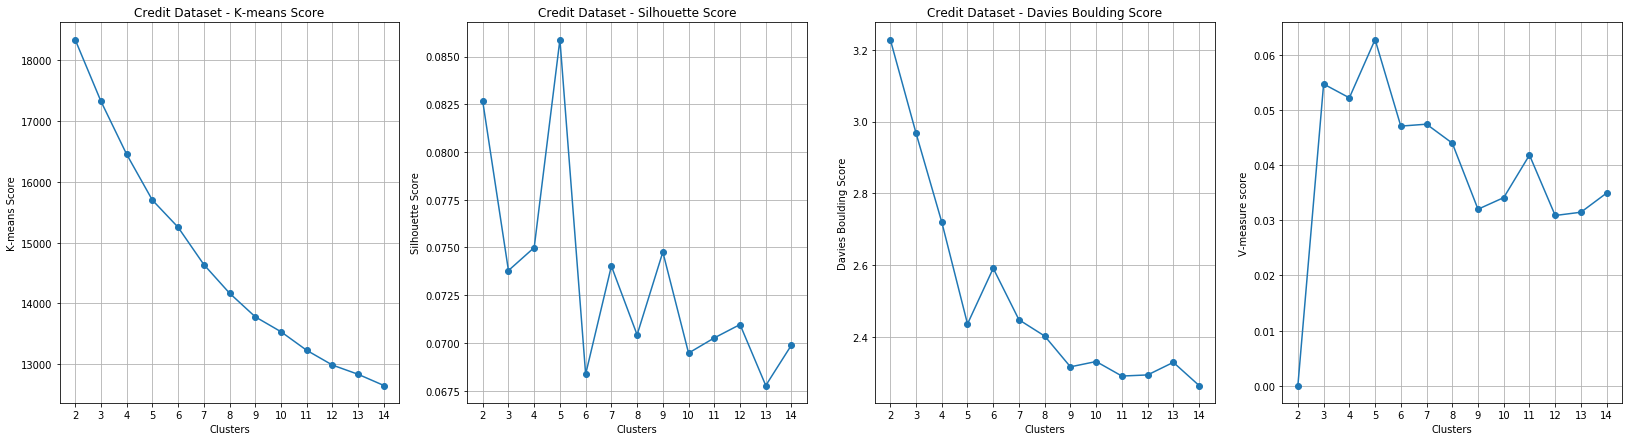

In [10]:
build_kmeans_plots(ctitle, ck,cs,cv,cd)

In [161]:
# 5 clusters Credit
Xc, yc, name = get_data(cred_full)
km_5 = KMeans(n_clusters=5,
                    init="k-means++",
                    n_jobs=-1,
                    precompute_distances=True,
                    random_state=random_state).fit(Xc)

km_5_pred = km_5.predict(Xc)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_5_pred, yc.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_5_pred, yc.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xc, km_5_pred))

Adjusted Rand Score:      0.04592434041831419
Homogeneity Score:        0.04503241619210194
Calinski Harabasz Score:  68.11925991251822


## Expectation Maximization

In [13]:
cgm_bic, cgm_score = build_gmm_data(cred_full)

Clusters:  2
BIC:            32101.808064871297
Log-likelihood: -14.458666440630266
----------------------------------------------------------------------------------------------------
Clusters:  3
BIC:            23218.396067032907
Log-likelihood: -9.219114706988634
----------------------------------------------------------------------------------------------------
Clusters:  4
BIC:            21045.39123590925
Log-likelihood: -7.33476655670437
----------------------------------------------------------------------------------------------------
Clusters:  5
BIC:            16402.418741201553
Log-likelihood: -4.215434574628083
----------------------------------------------------------------------------------------------------
Clusters:  6
BIC:            12934.920546436673
Log-likelihood: -1.6838397425232072
----------------------------------------------------------------------------------------------------
Clusters:  7
BIC:            11836.230883017784
Log-likelihood: -0.3366491760913

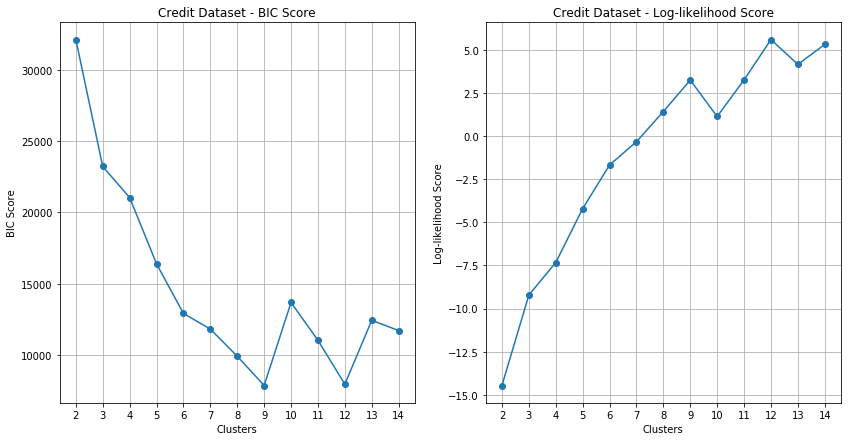

In [16]:
build_gmm_plots(ctitle, cgm_bic, cgm_score)

In [162]:
Xc, yc, _ = get_data(cred_full)

gmm_9_pred = GaussianMixture(n_components=9,
                              n_init=10,
                              tol=1e-3,
                              max_iter=1000).fit_predict(Xc)

In [163]:
print("Adjusted Rand Score:     ", adjusted_rand_score(gmm_9_pred, yc.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(gmm_9_pred, yc.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xc, gmm_9_pred))

Adjusted Rand Score:      0.03887729029863839
Homogeneity Score:        0.019109366775401506
Calinski Harabasz Score:  30.079647056231067


# MNIST

## K-means

In [26]:
mk, ms, mv, md = build_kmeans_elbow_data(mnist)

Clusters:  2
K-means score:        -2764050.10195047
Silhouette score:     0.08719975431023602
Davies Bouldin score: 3.736946816375304
V-measure score:      0.16435011499959964
----------------------------------------------------------------------------------------------------
Clusters:  3
K-means score:        -2628620.2784124827
Silhouette score:     0.05391723595662005
Davies Bouldin score: 3.2724287445499205
V-measure score:      0.2882257679329257
----------------------------------------------------------------------------------------------------
Clusters:  4
K-means score:        -2525711.9342540945
Silhouette score:     0.0602912135107325
Davies Bouldin score: 3.1407873660882526
V-measure score:      0.3799991510121182
----------------------------------------------------------------------------------------------------
Clusters:  5
K-means score:        -2432223.4710613666
Silhouette score:     0.0670478523136677
Davies Bouldin score: 2.924992770124756
V-measure score:      0.465

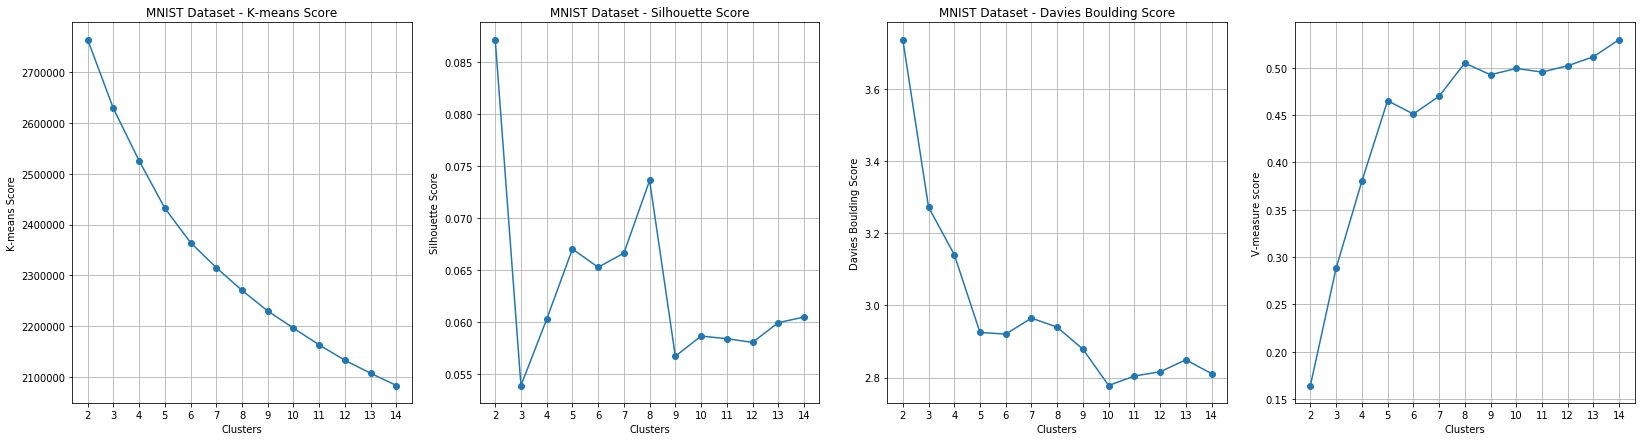

In [27]:
mtitle = "MNIST Dataset"
build_kmeans_plots(mtitle, mk,ms,mv,md)

In [28]:
# 8 clusters
Xm, ym, name = get_data(mnist)
km_8 = KMeans(n_clusters=8,
                    init="k-means++",
                    n_jobs=-1,
                    precompute_distances=True,
                    random_state=random_state).fit(Xm)

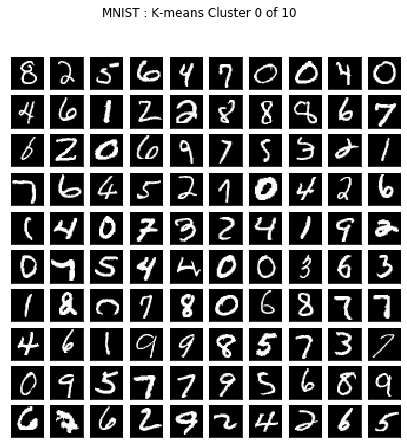

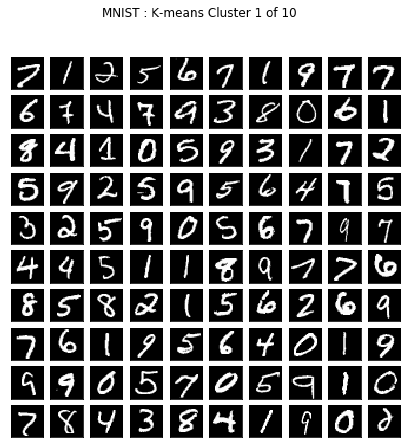

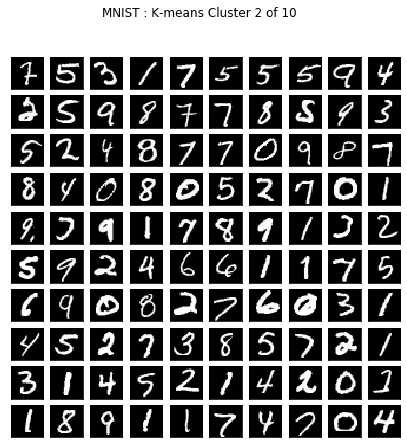

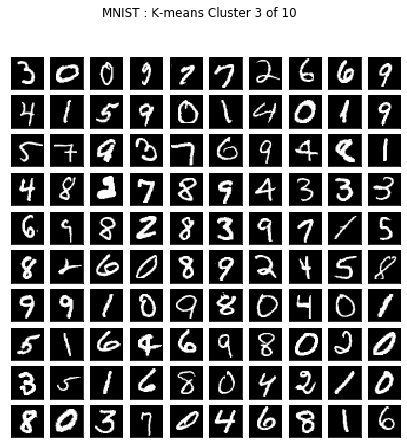

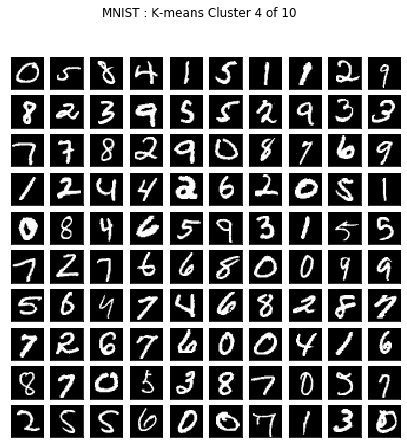

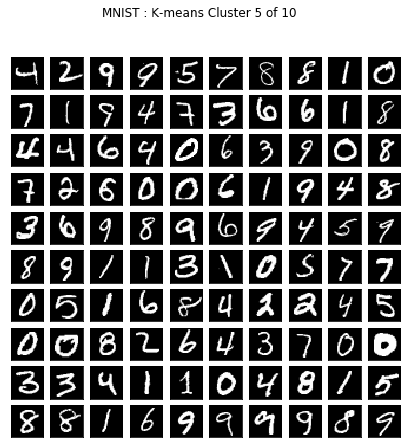

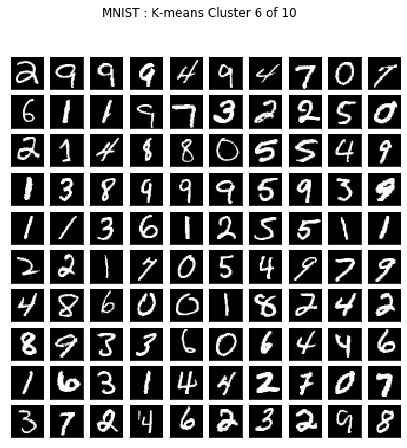

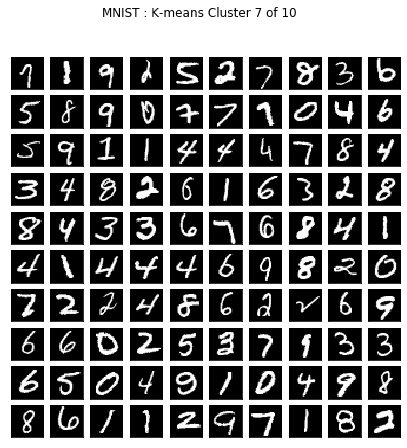

In [29]:
np.random.seed(random_state)
y_mnist_km8 = km_8.predict(Xm)
for i in range(8):
    ind = np.where(y_mnist_km8 == i)[0]
    ind8 = np.random.choice(ind,100, replace=False)
    show_digits(mnist_full, ind8, "MNIST : K-means Cluster {} of 10".format(i))

In [165]:
km_8_pred = km_8.predict(Xm)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_8_pred, ym.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_8_pred, ym.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xm, km_8_pred))

Adjusted Rand Score:      0.39488207145975995
Homogeneity Score:        0.5367349560384364
Calinski Harabasz Score:  2410.686472917905


## Expectation Maximization

In [7]:
mgm_bic, mgm_score = build_gmm_data(mnist_full)

Clusters:  2
BIC:            -259546022.5124738
Log-likelihood: 1903.0680677871778
----------------------------------------------------------------------------------------------------
Clusters:  3
BIC:            -283779905.2280347
Log-likelihood: 2100.751223376833
----------------------------------------------------------------------------------------------------
Clusters:  4
BIC:            -307315129.1239007
Log-likelihood: 2293.4439588258106
----------------------------------------------------------------------------------------------------
Clusters:  5
BIC:            -316073932.3080985
Log-likelihood: 2380.5908320485864
----------------------------------------------------------------------------------------------------
Clusters:  6
BIC:            -320422604.26916236
Log-likelihood: 2436.2367679632625
----------------------------------------------------------------------------------------------------
Clusters:  7
BIC:            -324841862.5925779
Log-likelihood: 2492.38689218045

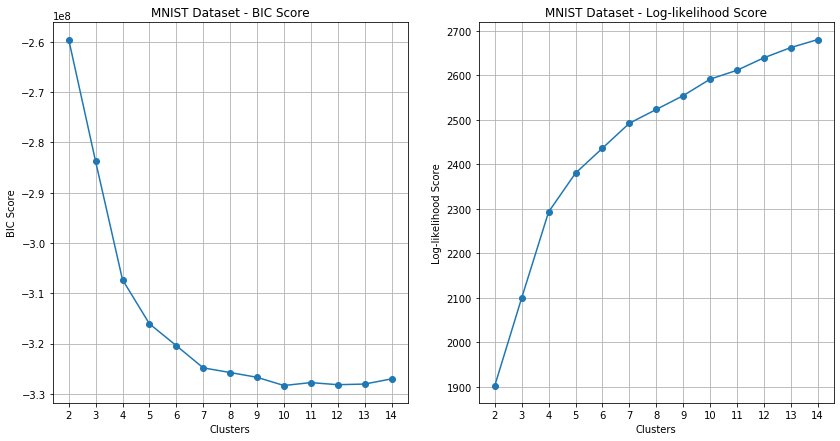

In [31]:
mtitle = "MNIST Dataset"
# Copied from EM log above to avoid re-running loooong calculations
mgm_bic = [-259546022.5, -283779905.2, -307315129.1, -316073932.3, -320422604.2,
           -324841862.5, -325767956.4, -326718260.7, -328350161.5, -327772881.2,
           -328189097.4, -328064132.8, -327034678.7]

mgm_score = [1903, 2100, 2293, 2380, 2436,
             2492, 2523, 2554, 2591, 2611,
             2639, 2662, 2680]
build_gmm_plots(mtitle, mgm_bic, mgm_score)

In [149]:
Xm, ym, _ = get_data(mnist)

gmm_10_pred = GaussianMixture(n_components=10,
                              n_init=10,
                              tol=1e-3,
                              max_iter=1000).fit(Xm)
gmm_10_pred_vals = gmm_10_pred.predict(Xm)

In [166]:
print("Adjusted Rand Score      ", adjusted_rand_score(gmm_10_pred_vals, ym.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(gmm_10_pred_vals, ym.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(Xm, gmm_10_pred_vals))

Adjusted Rand Score       0.1924852500925099
Homogeneity Score:        0.33726382192391874
Calinski Harabasz Score:  1088.508432947379


# Neural Networks

In [33]:
def build_confusion_matrix(clf, data_set):
    print(clf)
    X, y, name = get_data(data_set)
    title = "{} : {}".format(clf.__class__.__name__, name)
    disp = plot_confusion_matrix(clf, X, y, normalize="true", cmap=plt.cm.Blues)
    disp.ax_.set_title(title)

In [34]:
def build_learning_curve(clf, data_set, scoring="accuracy", axes=None, ylim=None, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    print(clf)
    X, y, name = get_data(data_set)
    title = "{} : {}".format(clf.__class__.__name__, name)
    
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(30, 10))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel(scoring)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        clf, X, y, cv=cv, n_jobs=n_jobs, scoring=scoring, train_sizes=train_sizes, return_times=True, random_state=random_state
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel(scoring)
    axes[2].set_title("Performance of the model")
    plt.show()

In [35]:
def print_gridsearch(data_set, parameters = {"random_state": random_state}, tuned_parameters={}, scores=["accuracy"]):
    X, y, name = get_data(data_set)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)

    best = []
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(MLPClassifier(**parameters), tuned_parameters, scoring=score, n_jobs=-1)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        best.append((clf.best_score_, clf.best_params_, clf.best_estimator_))
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

    print("Best parameters")
    for i in range(len(best)):
        print(scores[i])
        print(best[i])

In [133]:
def print_cross_val(clf, data_set, cv=5, v=1):
    print(clf)
    X, y, name = get_data(data_set)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy', verbose=v, n_jobs=-1)
    time.sleep(1)
    print("{} : {}".format(clf.__class__.__name__, name))
    print("Scores: ", scores, "Avg: ", np.mean(scores))

# K-means

In [170]:
# Add train cluster labels as OHE
X, y_train, _  = get_data(mnist)
enc = OneHotEncoder()
ohe = enc.fit_transform(km_8_pred.reshape(-1,1))
km_mnist_cluster_train = np.copy(X)
km_mnist_cluster_train = np.hstack([mnist_cluster_train, ohe.todense()])

In [171]:
# Add test cluster labels as OHE
X, y_test, _  = get_data(mnist_test)
enc = OneHotEncoder()
ohe = enc.fit_transform(km_8.predict(X).reshape(-1,1))
km_mnist_cluster_test = np.copy(X)
km_mnist_cluster_test = np.hstack([mnist_cluster_test, ohe.todense()])

In [172]:
# MNIST Neural Network
hidden_layer_sizes = (275, 275)
solver = "adam"
learning_rate= "invscaling"
alpha = 0.001
learning_rate_init = 0.001
mnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate,
                    learning_rate_init=learning_rate_init,
                    random_state=random_state)
mnn

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [136]:
print_cross_val(mnn, {"X": km_mnist_cluster_train, 'y': y_train, "name": "MNIST Train + cluster"})

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.4min finished


MLPClassifier : MNIST Train + cluster
Scores:  [0.98241071 0.97758929 0.98107143 0.98142857 0.98098214] Avg:  0.9806964285714285


In [173]:
# Fit
mnn = mnn.fit(km_mnist_cluster_train, y_train.values.ravel())

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Classification report for classifier MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',

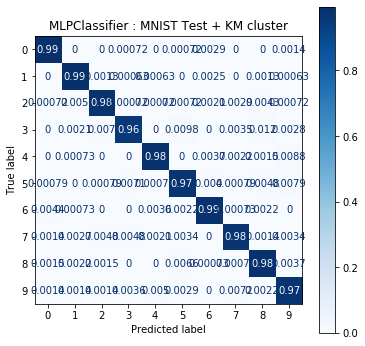

In [174]:
# Test
build_confusion_matrix(mnn, {"X": km_mnist_cluster_test, 'y': y_test, "name": "MNIST Test + KM cluster"})
predicted_mnist = mnn.predict(km_mnist_cluster_test)
print("Classification report for classifier %s:\n\n%s\n" % (mnn, classification_report(y_test, predicted_mnist)))

# EM

In [175]:
# Add train cluster labels as OHE
X, y_train, _  = get_data(mnist)
enc = OneHotEncoder()
ohe = enc.fit_transform(gmm_10_pred.predict(X).reshape(-1,1))
em_mnist_cluster_train = np.copy(X)
em_mnist_cluster_train = np.hstack([mnist_cluster_train, ohe.todense()])

In [176]:
# Add test cluster labels as OHE
X, y_test, _  = get_data(mnist_test)
enc = OneHotEncoder()
ohe = enc.fit_transform(gmm_10_pred.predict(X).reshape(-1,1))
em_mnist_cluster_test = np.copy(X)
em_mnist_cluster_test = np.hstack([mnist_cluster_test, ohe.todense()])

In [177]:
# MNIST Neural Network
hidden_layer_sizes = (275, 275)
solver = "adam"
learning_rate= "invscaling"
alpha = 0.001
learning_rate_init = 0.001
em_mnn = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,
                    solver=solver,
                    alpha=alpha,
                    learning_rate=learning_rate,
                    learning_rate_init=learning_rate_init,
                    random_state=random_state)
em_mnn

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [178]:
print_cross_val(em_mnn, {"X": em_mnist_cluster_train, 'y': y_train, "name": "MNIST Train + EM cluster"})

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 10.4min finished


MLPClassifier : MNIST Train + EM cluster
Scores:  [0.97669643 0.98035714 0.98267857 0.9825     0.98125   ] Avg:  0.9806964285714285


In [179]:
# Fit
em_mnn = mnn.fit(em_mnist_cluster_train, y_train.values.ravel())

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
Classification report for classifier MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',

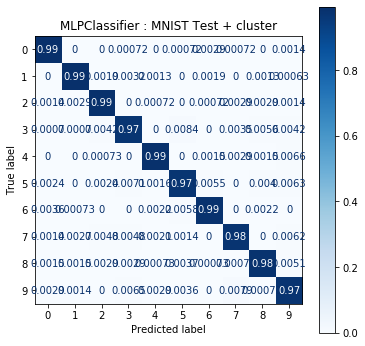

In [180]:
# Test
build_confusion_matrix(em_mnn, {"X": em_mnist_cluster_test, 'y': y_test, "name": "MNIST Test + cluster"})
predicted_mnist = em_mnn.predict(em_mnist_cluster_test)
print("Classification report for classifier %s:\n\n%s\n" % (mnn, classification_report(y_test, predicted_mnist)))

# Learning Curves

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


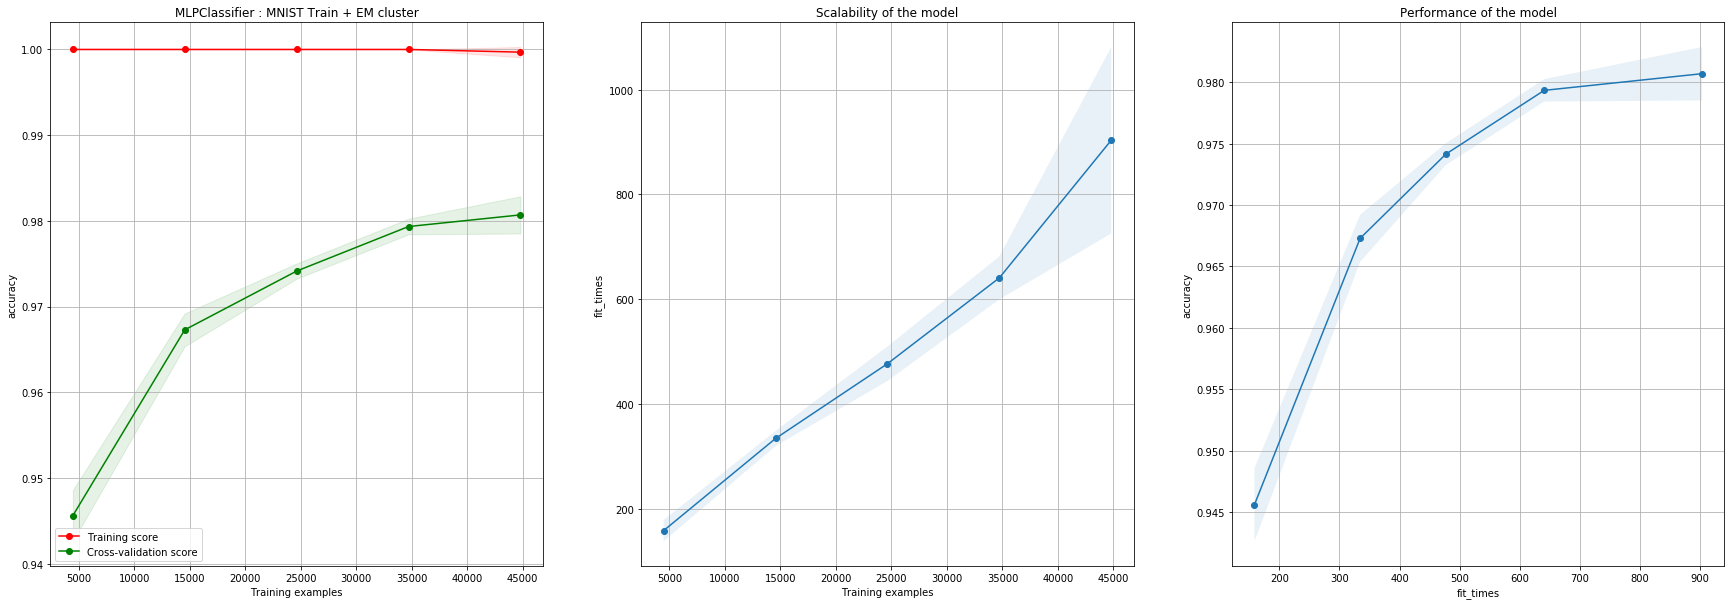

In [184]:
build_learning_curve(em_mnn, {"X": em_mnist_cluster_train, 'y': y_train, "name": "MNIST Train + EM cluster"}, scoring="accuracy")

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(275, 275), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=2020, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


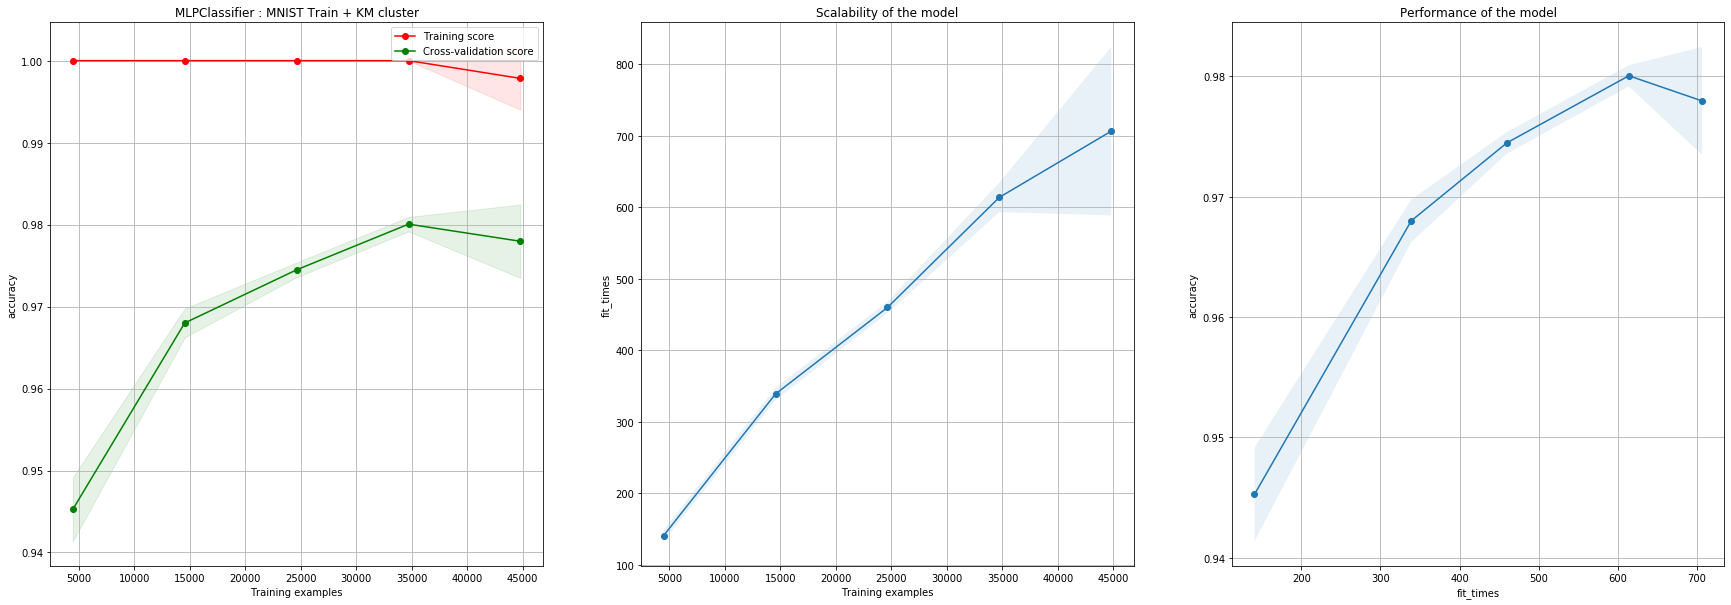

In [185]:
build_learning_curve(mnn, {"X": km_mnist_cluster_train, 'y': y_train, "name": "MNIST Train + KM cluster"}, scoring="accuracy")